## Crypto Portfolio Analysis

Here I will retrieve and clean portfolio data from my Kraken account where I have traded XRPGBP since 2023-01-17.

In [396]:
import krakenex 
from pykrakenapi import KrakenAPI
import pandas as pd
import numpy as np
import time, datetime
import gdown
from zipfile import ZipFile
import matplotlib.pyplot as plt
import seaborn as sns

In [361]:
# Get the API
api = krakenex.API()
api.load_key("kraken.key")

In [362]:
# Set first day of trading
start = datetime.datetime(2023, 1, 17)
since = int(start.timestamp())

In [363]:
# Geth the ledger entries
all_entries = []
ofs = 0

while True:
    resp = api.query_private('Ledgers', {
        'start': since,
        'ofs': ofs
    })
    result = resp.get('result', {})
    ledger = result.get('ledger', {})
    count  = int(result.get('count', 0))

    if not ledger:
        break

    # Append this batch
    batch_df = pd.DataFrame.from_dict(ledger, orient='index')
    all_entries.append(batch_df)

    ofs += len(ledger)              # move offset forward
    if ofs >= count:                # fetched all available entries
        break

    time.sleep(1)                   # be kind to the API

#Combine and clean up
df_ledger = pd.concat(all_entries, ignore_index=True)
df_ledger['time'] = pd.to_datetime(df_ledger['time'], unit='s')

# Now df_ledger contains every ledger entry from 2023-01-17 onward
print(df_ledger.shape)
df_ledger

(79, 9)


,aclass,amount,asset,balance,fee,refid,time,type,subtype
0,currency,0.0456137382,MINA.F,30.2590165490,0.0091227476,ELYIUNU-2EUDB-TGJ63N,2025-05-10 23:31:08.401307106,staking,
1,currency,0.0765319454,MINA.F,30.2225255584,0.0153063890,EL75JL4-PBUUP-EX5NRC,2025-05-05 15:25:37.347942114,staking,
2,currency,0.0696420339,MINA.F,30.1613000020,0.0139284067,EL5XOFM-K6YA2-IZ6N75,2025-04-28 14:39:59.242795944,staking,
3,currency,0.0851383482,MINA.F,30.1055863748,0.0170276696,EL6DO6E-SKNII-T75DLE,2025-04-21 14:40:09.360488892,staking,
4,currency,0.0570769521,MINA.F,30.0374756962,0.0114153904,EL3ULYM-GAYAY-STUTEU,2025-04-14 14:40:11.778827906,staking,
...,...,...,...,...,...,...,...,...,...
74,currency,199.8758,ZGBP,200.0378,0.5196,TSVTTR-VM5BP-44BB4H,2023-03-27 12:59:37.333776951,trade,tradespot
75,currency,-508.72462735,XXRP,159.73355202,0.00000000,TSVTTR-VM5BP-44BB4H,2023-03-27 12:59:37.333772898,trade,tradespot
76,currency,668.45817937,XXRP,668.45817937,0.00000000,TDMDKV-USYPR-54G5IN,2023-01-18 16:22:09.525471926,trade,tradespot
77,currency,-199.0000,ZGBP,0.6816,0.3184,TDMDKV-USYPR-54G5IN,2023-01-18 16:22:09.525468111,trade,tradespot


In [364]:
# We focus only on XRP and GBP, XXRP and ZGBP respectively
pf_gbp = df_ledger[df_ledger['asset'] == 'ZGBP'][['time', 'balance', 'type']]
pf_gbp['time'] = pf_gbp['time'].dt.date
pf_gbp.rename(columns={'time': 'date', 'balance': 'balance_gbp'}, inplace=True)
pf_gbp['date'] = pd.to_datetime(pf_gbp['date'])
print(pf_gbp.dtypes)
print(pf_gbp.head(), '\n\n')

pf_xrp = df_ledger[df_ledger['asset'] == 'XXRP'][['time', 'balance']]
pf_xrp['time'] = pf_xrp['time'].dt.date
pf_xrp.rename(columns={'time': 'date', 'balance': 'balance_xrp'}, inplace=True)
pf_xrp['date'] = pd.to_datetime(pf_xrp['date'])
print(pf_xrp.dtypes)
print(pf_xrp.head())

date           datetime64[ns]
balance_gbp            object
type                   object
dtype: object
         date balance_gbp        type
16 2025-02-02     72.3178       spend
25 2024-12-10    127.3178       spend
30 2024-12-02    158.3178       spend
31 2024-12-02    178.3178  withdrawal
32 2024-11-19    380.2678     receive 


date           datetime64[ns]
balance_xrp            object
dtype: object
         date   balance_xrp
15 2025-02-02  308.16273202
24 2024-12-10  282.35931202
33 2024-11-19  261.97605202
35 2024-11-16  366.85589202
37 2024-08-07  399.79974202


In [365]:
# Clean up the trading activities dataframe
df_portfolio = pd.merge(pf_gbp, pf_xrp, on='date', how='outer')
df_portfolio = df_portfolio.ffill()
df_portfolio = df_portfolio.fillna(0)
df_portfolio = df_portfolio.loc[df_portfolio.groupby('date').apply(lambda x: x.index.max(), include_groups=False)]
df_portfolio[['balance_gbp', 'balance_xrp']] = df_portfolio[['balance_gbp', 'balance_xrp']].astype(float)
#df_portfolio.set_index('date', inplace=True)
print(df_portfolio.dtypes)
df_portfolio.loc[1, 'type'] = 'buy'
df_portfolio.loc[2, 'type'] = 'sell'
df_portfolio['type'] = df_portfolio['type'].replace('receive', 'sell')
df_portfolio['type'] = df_portfolio['type'].replace('spend', 'buy')
df_portfolio

date           datetime64[ns]
balance_gbp           float64
type                   object
balance_xrp           float64
dtype: object


,date,balance_gbp,type,balance_xrp
0,2023-01-17,200.0000,deposit,0.000000
1,2023-01-18,0.6816,buy,668.458179
2,2023-03-27,200.0378,sell,159.733552
3,2023-03-29,215.0378,sell,126.911852
4,2023-05-08,0.0078,buy,766.156942
5,2023-06-04,28.0478,sell,700.000002
6,2023-06-22,165.7178,sell,350.000002
7,2023-07-14,270.2578,sell,175.000002
8,2023-08-19,133.2578,buy,513.440082
9,2023-11-06,228.9778,sell,344.619352


In [366]:
# Get the Kraken OHLCVT data
# Download the ZIP to a local file
FILE_ID = "1ptNqWYidLkhb2VAKuLCxmp2OXEfGO-AP"
url     = f"https://drive.google.com/uc?id={FILE_ID}"
output  = "kraken_OHLCVT_all_pairs.zip"

In [367]:
#gdown.download(url, output, quiet=False)  # handles large-file token dance :contentReference[oaicite:6]{index=6}

In [368]:
# Get the XRPGBP OHLCVT data from the ZIP file
cols = [
    "date",   # UNIX timestamp
    "open",    # first price
    "high",    # max price
    "low",     # min price
    "close",   # last price
    "volume",  # total volume
    "count"    # number of trades
]

# Open & extract daily CSV(s)
with ZipFile(output, 'r') as zipf:
    frames = []
    for fname in zipf.namelist():
        if fname.endswith("XRPGBP_1440.csv"):
            with zipf.open(fname) as f:
                df = pd.read_csv(
                    f,
                    header=None,        # file has no header row
                    names=cols,         # assign our column names
                    parse_dates=["date"],    # parse 'start' as datetime
                    index_col="date"         # set it as the index
                )
                frames.append(df)

xrp_gbp_daily = pd.concat(frames, axis=0).sort_index()

print(f"Loaded {len(xrp_gbp_daily)} daily bars")
#print(f"Date range: {xrp_gbp_daily.index.min().date()} → {xrp_gbp_daily.index.max().date()}")
xrp_gbp_daily

Loaded 1797 daily bars


/var/folders/wq/18gg8ft12lx3lcnj_y9kk1qc0000gp/T/ipykernel_70937/3164393652.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(


,open,high,low,close,volume,count
date,,,,,,
1588204800,0.21300,0.21300,0.21300,0.21300,1000.000000,1
1588291200,0.21299,0.21299,0.17057,0.17681,50463.086203,33
1588377600,0.17628,0.18468,0.17254,0.18468,27405.146686,30
1588464000,0.18499,0.18656,0.17100,0.17728,70738.084518,30
1588550400,0.17452,0.17744,0.16981,0.17712,26495.925152,114
...,...,...,...,...,...,...
1743033600,1.82490,1.85034,1.78180,1.80610,358330.515091,1469
1743120000,1.80606,1.80676,1.66451,1.70484,658457.591568,2877
1743206400,1.70575,1.71936,1.59215,1.65504,553156.111291,2366


In [369]:
# Convert the index to a datetime object
xrp_gbp_daily.index = pd.to_datetime(
    xrp_gbp_daily.index,
    unit='s',      # specify that the ints are seconds since 1970-01-01
    origin='unix'  # (this is the default, but shown here for clarity)
)

# Get the market data since the start date
xrp_gbp_daily = pd.DataFrame(xrp_gbp_daily['close'])
xrp_gbp_daily = xrp_gbp_daily[xrp_gbp_daily.index >= start]
xrp_gbp_daily

# Merge the portfolio with the market data
full_portfolio = pd.merge(
    xrp_gbp_daily,
    df_portfolio,
    left_on='date',
    right_on='date',
    how='left'
)
# Create 'hold' entries for days without trades
full_portfolio['type'] = full_portfolio['type'].fillna('hold')
full_portfolio = full_portfolio.ffill()

# Calculate the total portfolio value
full_portfolio['total_gbp'] = full_portfolio['close'] * full_portfolio['balance_xrp'] + full_portfolio['balance_gbp']
print(full_portfolio.dtypes)

# Create a buy-and-hold strategy, replicating the initial investment
buy_and_hold = [200] 
for i in full_portfolio['close'].iloc[1:]:
    buy_and_hold.append(i*200/full_portfolio['close'].iloc[0])

full_portfolio['buy_and_hold'] = buy_and_hold
full_portfolio['returns'] = full_portfolio['total_gbp'].pct_change()
full_portfolio['market_returns'] = full_portfolio['buy_and_hold'].pct_change()
full_portfolio

date           datetime64[ns]
close                 float64
balance_gbp           float64
type                   object
balance_xrp           float64
total_gbp             float64
dtype: object


,date,close,balance_gbp,type,balance_xrp,total_gbp,buy_and_hold,returns,market_returns
0,2023-01-17,0.31500,200.0000,deposit,0.000000,200.000000,200.000000,NaN,NaN
1,2023-01-18,0.30649,0.6816,buy,668.458179,205.557347,194.596825,0.027787,-0.027016
2,2023-01-19,0.31729,0.6816,hold,668.458179,212.776696,201.453968,0.035121,0.035238
3,2023-01-20,0.33315,0.6816,hold,668.458179,223.378442,211.523810,0.049826,0.049986
4,2023-01-21,0.32558,0.6816,hold,668.458179,218.318214,206.717460,-0.022653,-0.022722
...,...,...,...,...,...,...,...,...,...
800,2025-03-27,1.80610,72.3178,hold,308.162732,628.890510,1146.730159,-0.009215,-0.010400
801,2025-03-28,1.70484,72.3178,hold,308.162732,597.685952,1082.438095,-0.049618,-0.056066
802,2025-03-29,1.65504,72.3178,hold,308.162732,582.339448,1050.819048,-0.025677,-0.029211
803,2025-03-30,1.65105,72.3178,hold,308.162732,581.109879,1048.285714,-0.002111,-0.002411


In [370]:
# Get the withdrawal date, can use to analyze portfolio pre and post withdrawal
withdrawal_date = full_portfolio.loc[full_portfolio['type'] == 'withdrawal', 'date'].values
withdrawal_date[0]

#full_portfolio = full_portfolio[full_portfolio['date'] < withdrawal_date[0]]
full_portfolio

,date,close,balance_gbp,type,balance_xrp,total_gbp,buy_and_hold,returns,market_returns
0,2023-01-17,0.31500,200.0000,deposit,0.000000,200.000000,200.000000,NaN,NaN
1,2023-01-18,0.30649,0.6816,buy,668.458179,205.557347,194.596825,0.027787,-0.027016
2,2023-01-19,0.31729,0.6816,hold,668.458179,212.776696,201.453968,0.035121,0.035238
3,2023-01-20,0.33315,0.6816,hold,668.458179,223.378442,211.523810,0.049826,0.049986
4,2023-01-21,0.32558,0.6816,hold,668.458179,218.318214,206.717460,-0.022653,-0.022722
...,...,...,...,...,...,...,...,...,...
800,2025-03-27,1.80610,72.3178,hold,308.162732,628.890510,1146.730159,-0.009215,-0.010400
801,2025-03-28,1.70484,72.3178,hold,308.162732,597.685952,1082.438095,-0.049618,-0.056066
802,2025-03-29,1.65504,72.3178,hold,308.162732,582.339448,1050.819048,-0.025677,-0.029211
803,2025-03-30,1.65105,72.3178,hold,308.162732,581.109879,1048.285714,-0.002111,-0.002411


## Analysis
Now we are ready to perform analysis and calculate different metrics.

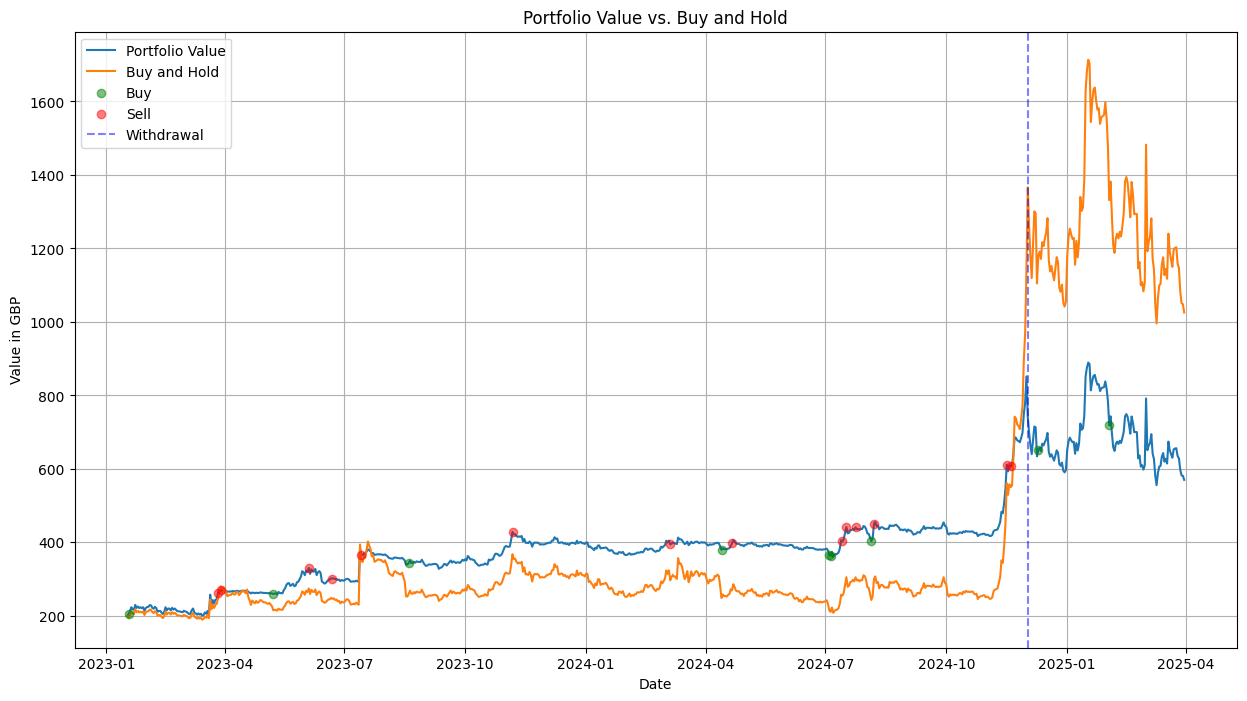

In [371]:
# Plot the portfolio value and buy-and-hold strategy
plt.figure(figsize=(15, 8))
plt.plot(full_portfolio['date'], full_portfolio['total_gbp'], label='Portfolio Value')
plt.plot(full_portfolio['date'], full_portfolio['buy_and_hold'], label='Buy and Hold')
plt.title('Portfolio Value vs. Buy and Hold')
plt.xlabel('Date')
plt.ylabel('Value in GBP')
# Add green circles for 'buy' and red circles for 'sell'
buy_points = full_portfolio[full_portfolio['type'] == 'buy']
sell_points = full_portfolio[full_portfolio['type'] == 'sell']
withdrawal_points = full_portfolio[full_portfolio['type'] == 'withdrawal']

plt.scatter(buy_points['date'], buy_points['total_gbp'], color='green', label='Buy', zorder=5, alpha=0.5)
plt.scatter(sell_points['date'], sell_points['total_gbp'], color='red', label='Sell', zorder=5, alpha=0.5)

# Add vertical lines for 'withdrawal'
for withdrawal_date in withdrawal_points['date']:
    plt.axvline(x=withdrawal_date, color='blue', linestyle='--', label='Withdrawal', alpha=0.5)

plt.grid(True)
plt.legend()
plt.show();

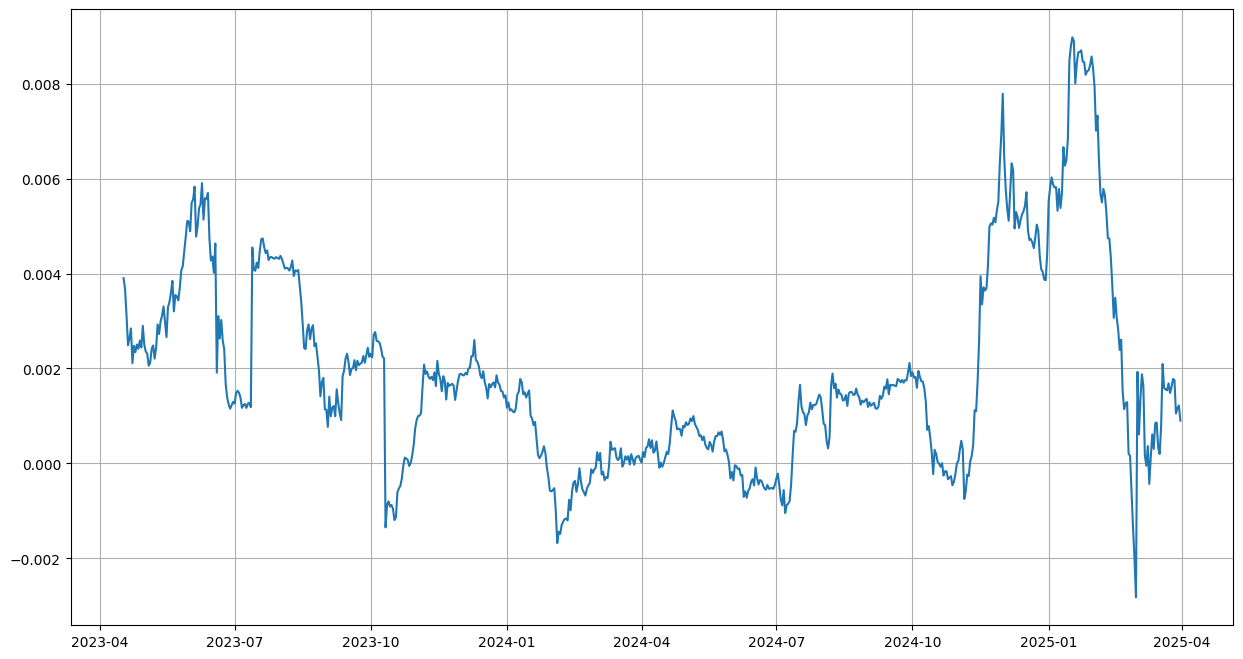

In [394]:
pf_90d_rets = full_portfolio['returns'].rolling(90).mean()
plt.figure(figsize=(15, 8))
plt.plot(full_portfolio['date'], pf_90d_rets, label='90-day rolling returns')
plt.grid(True)
plt.show();

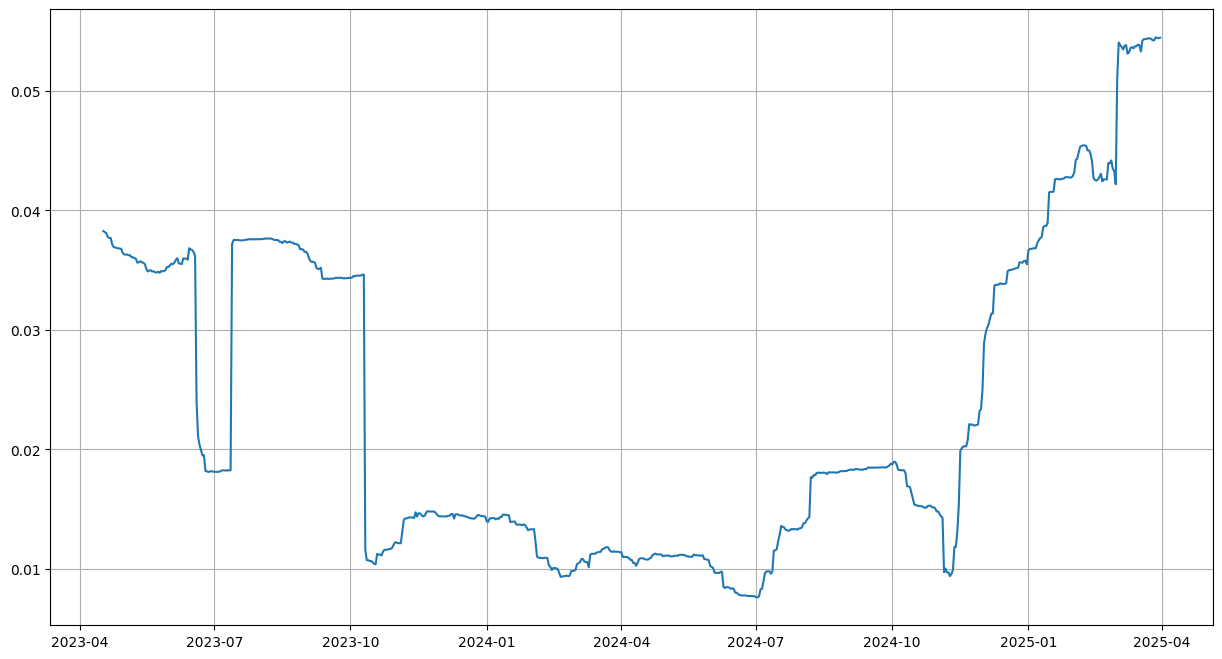

In [393]:
pf_90d_vol = full_portfolio['returns'].rolling(90).std()
plt.figure(figsize=(15, 8))
plt.plot(full_portfolio['date'], pf_90d_vol, label='90-day rolling volatility')
plt.grid(True)
plt.show();

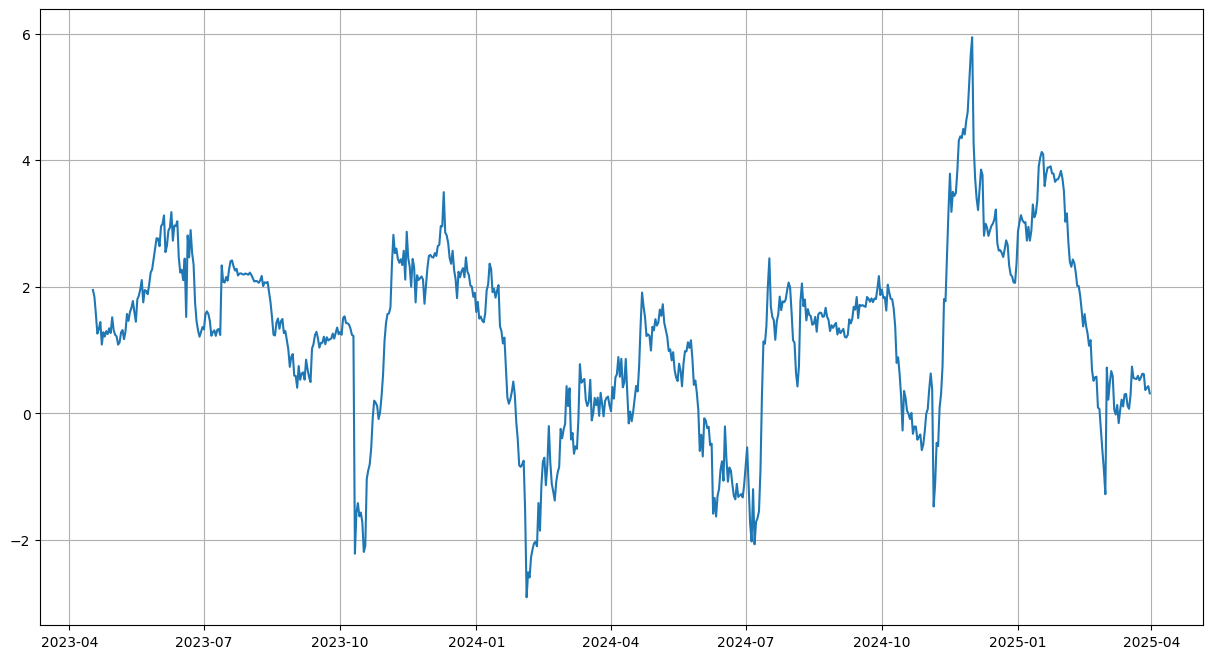

1.2504781356288337


In [401]:
sharpe_ratio_rolling = pf_90d_rets/pf_90d_vol*np.sqrt(365)
plt.figure(figsize=(15, 8))
plt.plot(full_portfolio['date'], sharpe_ratio_rolling, label='90 day rolling sharpe')
plt.grid(True)
plt.show();
print(sharpe_ratio_rolling.mean())

### Pearson Correlation

In [372]:
returns = full_portfolio['returns'].dropna()
market_returns = full_portfolio['market_returns'].dropna()

corr = returns.corr(market_returns)
print(f"Correlation between portfolio and market: {corr:.2f}")

Correlation between portfolio and market: 0.88


### Sharpe Ratio (Annualized)

In [389]:
mean_returns = returns.mean()
std_returns = returns.std()
sharpe_ratio = mean_returns / std_returns * np.sqrt(365)
print(f"Portfolio Sharpe ratio: {sharpe_ratio:.4f}")

mean_market_returns = market_returns.mean()
std_market_returns = market_returns.std()
sharpe_ratio_market = mean_market_returns / std_market_returns * np.sqrt(365)
print(f"Market Sharpe ratio : {sharpe_ratio_market:.4f}")

Portfolio Sharpe ratio: 1.1066
Market Sharpe ratio : 1.2127


### Sortino Ratio

In [374]:
downside_returns = returns[returns < 0]
downside_std = downside_returns.std()
sortino_ratio = mean_returns / downside_std * np.sqrt(365)
print(f"Portfolio Sortino ratio: {sortino_ratio:.4f}")

downside_market_returns = market_returns[market_returns < 0]
downside_market_std = downside_market_returns.std()
sortino_ratio_market = mean_market_returns / downside_market_std * np.sqrt(365)
print(f"Market Sortino ratio: {sortino_ratio_market:.4f}")

Portfolio Sortino ratio: 1.7048
Market Sortino ratio: 2.3395


### Cummulative Return

Portfolio cummulative return: 185.06%
Market cummulative return: 412.82%


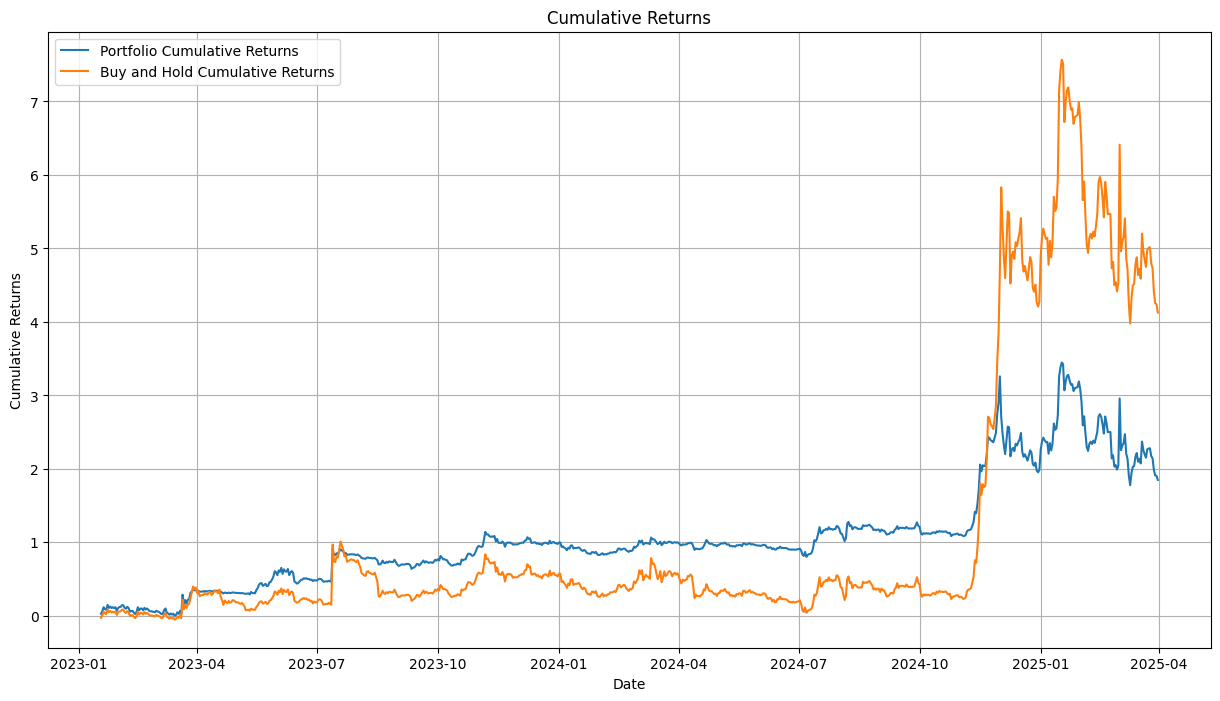

In [375]:
cummulative_returns = (1 + returns).cumprod() - 1
cummulative_market_returns = (1 + market_returns).cumprod() - 1
print(f"Portfolio cummulative return: {cummulative_returns.iloc[-1]:.2%}")
print(f"Market cummulative return: {cummulative_market_returns.iloc[-1]:.2%}")

plt.figure(figsize=(15, 8))
plt.plot(full_portfolio['date'].iloc[1:], cummulative_returns, label='Portfolio Cumulative Returns')
plt.plot(full_portfolio['date'].iloc[1:], cummulative_market_returns, label='Buy and Hold Cumulative Returns')
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.grid(True)
plt.legend()
plt.show();


### Annualized Return

In [376]:
annualized_return = ((1 + returns.mean()) ** 365) - 1  # Assuming daily returns
print(f'Annualized Portfolio Return: {annualized_return:.2%}')

annualized_market_return = ((1 + market_returns.mean()) ** 365) - 1  # Assuming daily returns
print(f'Annualized Market Return: {annualized_market_return:.2%}')

Annualized Portfolio Return: 87.48%
Annualized Market Return: 207.71%


### Volatility  

In [377]:
volatility = returns.std() * np.sqrt(365)  # Annualized volatility
print(f'Portfolio Volatility: {volatility:.4f}')

market_volatility = market_returns.std() * np.sqrt(365)
print(f'Market Volatility: {market_volatility:.4f}')

Portfolio Volatility: 0.5684
Market Volatility: 0.9282


### Drawdown

In [378]:
# Max Portfolio Drawdown
cumulative_returns = (1 + returns).cumprod()
peak = cumulative_returns.cummax()
max_drawdown = (cumulative_returns - peak) / peak
max_drawdown_value = max_drawdown.min()
print(f'Max Portfolio Drawdown: {max_drawdown_value:.2%}')

# Max Market Drawdown
cumulative_market_returns = (1 + market_returns).cumprod()
market_peak = cumulative_market_returns.cummax()
max_market_drawdown = (cumulative_market_returns - peak) / peak
max_market_drawdown_value = max_market_drawdown.min()
print(f'Max Market Drawdown: {max_market_drawdown_value:.2%}')

Max Portfolio Drawdown: -37.52%
Max Market Drawdown: -51.44%


In [379]:
# max_drawdown[max_drawdown == max_drawdown.min()].index[0]
# full_portfolio.iloc[max_drawdown[max_drawdown == max_drawdown.min()].index[0]]

### Calmar Ratio    

In [380]:
calmar_ratio = annualized_return / abs(max_drawdown_value)
market_calmar_ratio = annualized_market_return / abs(max_market_drawdown_value)
print(f'Portfolio Calmar Ratio: {calmar_ratio:.4f}')
print(f'Market Calmar Ratio: {market_calmar_ratio:.4f}')

Portfolio Calmar Ratio: 2.3314
Market Calmar Ratio: 4.0380


In [381]:
beta = np.cov(returns, market_returns)[0][1] / np.var(market_returns)
print(f'Portfolio Beta: {beta:.4f}')

Portfolio Beta: 0.5389


### Alpha

In [382]:
ex_return = beta * (market_returns.mean() - 0.01)  # Assuming a risk-free rate of 1%
alpha = mean_returns - ex_return
print(f'Portfolio Alpha: {alpha:.4f}')

Portfolio Alpha: 0.0055


### Treynor Ratio   


In [383]:
treynor_ratio = mean_returns / beta
print(f'Portfolio Treynor Ratio: {treynor_ratio:.2%}')

Portfolio Treynor Ratio: 0.32%


###  Information Ratio

In [384]:
active_return = returns - market_returns
avg_active_return = active_return.mean()
tracking_error = active_return.std()*np.sqrt(365)  # Annualized tracking error
ir = avg_active_return / tracking_error
print(f'Information Ratio: {ir:.4f}')

Information Ratio: -0.0027


### Value at Risk (VaR)

In [385]:
var_95 = returns.quantile(0.05)
print(f'Value at Risk (VaR) at 95% confidence level: {var_95:.2%}')

es_95 = returns[returns <= var_95].mean()
print(f'Expected Shortfall (ES) at 95% confidence level: {es_95:.2%}')

Value at Risk (VaR) at 95% confidence level: -3.45%
Expected Shortfall (ES) at 95% confidence level: -5.82%


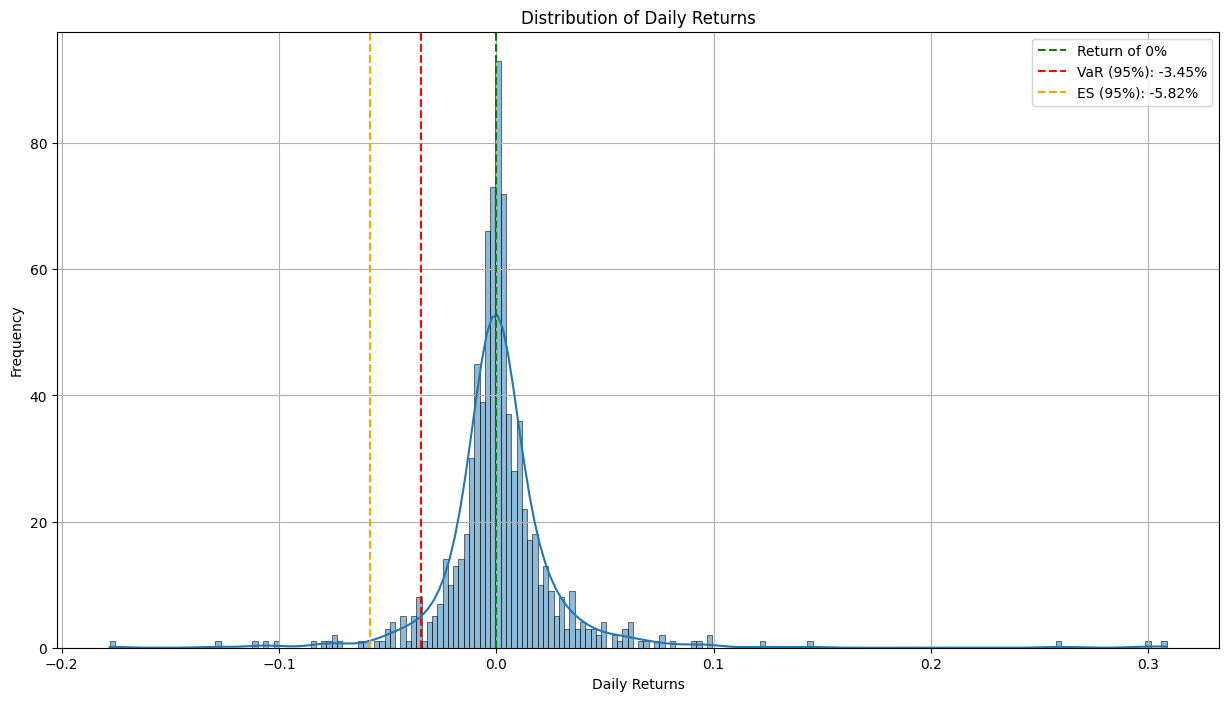

In [ ]:
plt.figure(figsize=(15, 8))
sns.histplot(returns, bins=200, kde=True, edgecolor='black')
plt.axvline(x=0, color='g', linestyle='--', label='Return of 0%')
plt.axvline(x=var_95, color='r', linestyle='--', label=f'VaR (95%): {var_95:.2%}')
plt.axvline(x=es_95, color='orange', linestyle='--', label=f'ES (95%): {es_95:.2%}')
plt.title('Distribution of Daily Returns')
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.grid(True)
plt.legend()
plt.show();

### Monte Carlo Simulation

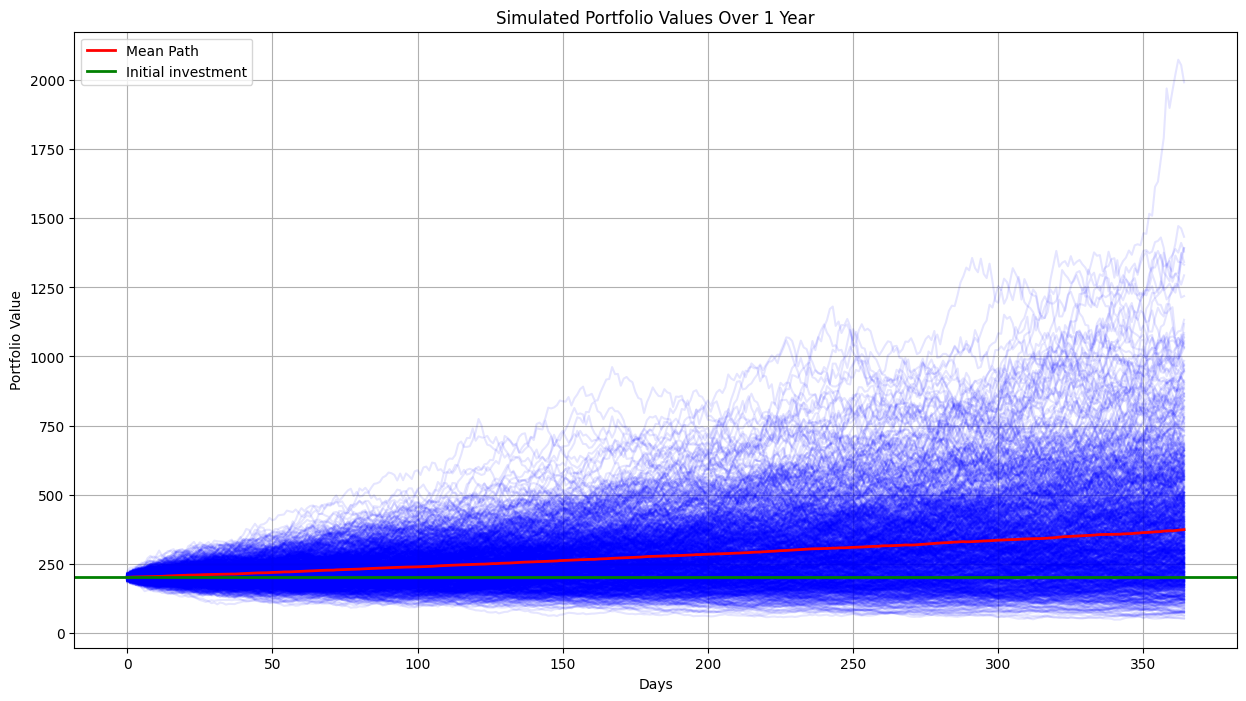

In [387]:
initial_investment = 200
days = 365
simulations = 1000
np.random.seed(42)  # For reproducibility

simulated_returns = np.random.normal(
    loc=returns.mean(),
    scale=returns.std(),
    size=(days, simulations)
)
simulated_portfolio_values = initial_investment * (1 + simulated_returns).cumprod(axis=0)

mean_path = simulated_portfolio_values.mean(axis=1)

plt.figure(figsize=(15, 8))
plt.plot(simulated_portfolio_values, color='blue', alpha=0.1)
plt.plot(mean_path, color='red', label='Mean Path', linewidth=2)
plt.axhline(y=initial_investment, color='green', label='Initial investment', linewidth=2)
plt.title('Simulated Portfolio Values Over 1 Year')
plt.xlabel('Days')
plt.ylabel('Portfolio Value')
plt.grid(True)
plt.legend()
plt.show();